In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
import plotly.graph_objs as go
import numdifftools
import lmfit
import corner
import emcee
from IPython.display import display, Math

In [2]:
def B_spline(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B_spline(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B_spline(x, k-1, i+1, t)
    return c1 + c2


def T(x, x_knots, b):
    """
    time strategy
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B_spline(x, 3, i, t)
    
    return T*3*3600*24*365 #3 years

In [3]:
#functions from https://github.com/cajohare/IAXOmass/blob/master/code/AxionFuncs.py
def PhotonNumber_Primakoff(E,m_a,\
                           Bfield=2.5,Exposure=1.5,Length=20.0,\
                           N_bores=8,BoreDiameter=60.0,eps_D=0.7,eps_T=0.8):
    """
    differential Xray count dN/dE (in keV^-1) for axionphoton flux
    E = Xray energy (keV)
    m_a = axion mass (eV)
    """
    norm,normq = NgammaNorm(Bfield,Exposure,Length,N_bores,BoreDiameter,eps_D,eps_T)
    return norm*((E**2.481)/np.exp(E/1.205))*(np.sinc(normq/np.pi*m_a**2.0/E))**2.0  # keV^-1


def NgammaNorm(Bfield,Exposure,Length,N_bores,BoreDiameter,eps_D,eps_T):
    """
    normalisation of overall photon number to get it in keV^-1 and constant that enters into t
    """
    S_cm = N_bores*np.pi*(BoreDiameter/2.0)**2.0 # cm^2
    L_eV = Length/1.97e-7 # 1/E=L/c·ħ eV^-1
    t_secs = 1 # s
    B = Bfield*(1e-19*195) 
    norm = 6.02e10*t_secs*S_cm*eps_D*eps_T*(B*L_eV/2.0)**2.0
    normq = L_eV/(4*1000) # keV^-1, 1/4 from q/2
    return norm, normq


def experiment(E, m_a, noise, calibr):
    return calibr*PhotonNumber_Primakoff(E,m_a) + noise

In [66]:
def div_mass(E, m_a, \
             Bfield=2.5,Exposure=1.5,Length=20.0,\
             N_bores=8,BoreDiameter=60.0,eps_D=0.7,eps_T=0.8):
    """
    derivative of axion mass parameter 
    """
    norm, normq = NgammaNorm(Bfield,Exposure,Length,N_bores,BoreDiameter,eps_D,eps_T)
    x = normq*m_a**2.0/E
    return norm*((E**2.481)/np.exp(E/1.205))*2*np.sinc(x/np.pi)*(x*np.cos(x)-np.sin(x))/(x**2)*2*x/m_a



def div_cal(energy, m):
    """
    derivative of calibration parameter 
    """
    return PhotonNumber_Primakoff(energy, m)


#derivative of noise is equal to one


def inversed_fisher_information(b, x_knots, derivatives, KEs, dist):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    time = np.array([T(x, x_knots, b) for x in KEs])
    summ = np.sum(time)
    b0 = np.ones(len(x_knots) - 6)
    y0 = np.array([T(x, x_knots, b0) for x in KEs])
    normolize = np.sum(y0)
    time = time * normolize / summ
    length = len(derivatives)
    FIM = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    return np.sqrt(np.linalg.inv(FIM)[0][0])

In [70]:
#params
n = 1000
m = 0.01 #axion mass, eV
#g = 10**-11

a0 = 0.1 #start of grid
a1 = 16 #end of grid
energy = np.linspace(a0, a1, n)
numbers = PhotonNumber_Primakoff(energy, m)
x_knots = np.concatenate([np.linspace(a0-2, a0-0.5, 3), np.linspace(a0, a1, 10), np.linspace(a1 + 1.5, a1 + 3.5, 3)])
derivatives = np.array([div_mass(energy, m), np.ones(n), div_cal(energy, m)]) 
b0 = np.ones(len(x_knots) - 6) #initial weights
bl = tuple(np.zeros(len(x_knots) - 6)) #lower bound
bw = tuple(np.ones(len(x_knots) - 6)*50) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [62]:
inversed_fisher_information(b0, x_knots, derivatives, energy, numbers)

array([[ 1.95586392e+06,  4.17288909e-06,  2.68806419e-02],
       [ 4.17288909e-06,  9.29287380e-16, -4.38853287e-13],
       [ 2.68806419e-02, -4.38853287e-13,  6.44717259e-09]])

In [71]:
inversed_fisher_information(b0, x_knots, derivatives, energy, numbers)#/inversed_fisher_information(b4, x_knots, derivatives, energy, numbers)

6.992430706221172e-07

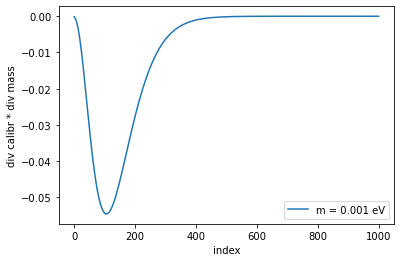

In [185]:
plt.plot(derivatives[2]*derivatives[0]*100000, label='m = 0.001 eV')
plt.xlabel('index')
plt.ylabel('div calibr * div mass')
plt.legend()
#plt.savefig('axion_figs/div_mass_calibr_m_001.png', dpi=300)

In [398]:
for m in [0.1, 0.02, 0.001, 0.0001]:
    numbers = PhotonNumber_Primakoff(energy, m)
    derivatives = np.array([div_mass(energy, m), np.ones(n), div_cal(energy, m)]) 
    print(inversed_fisher_information(b0, x_knots, derivatives, energy, numbers)/inversed_fisher_information(b1, x_knots, derivatives, energy, numbers))   
    #numbers = numbers * 0.1 / np.sum(numbers)
    #plt.plot(energy, numbers, label= str(m) + " eV")

#plt.legend()
#plt.xlabel('energy, keV')
#plt.ylabel('intensity (normolized)')
#plt.tight_layout()
#plt.savefig('axion_spectra.png', dpi=300, transparent=True) 

0.9743958227146255
1.9137043894812094
2.917276082519782
2.9193059357248305


In [12]:
#weights
bo = [5.75616546, 0.        , 0.        , 0.        , 2.96976327,
       0.91182758, 0.        , 0.        , 0.        , 0.23220813] #from neutrinos
b1 = [3.49103008, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.65695738] #for m=0.001
b2 = [4.99999939e+01, 1.26775429e-05, 2.51120106e-05, 2.70896555e-04,
       6.68700036e-05, 6.28279879e-05, 5.70137582e-05, 9.94056182e-06,
       5.16127349e-05, 1.03665135e+01] #for m=0.001 with annealing
b3 = [2.16081462, 3.15161278, 0.        , 0.19480526, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ] #for m=0.02
b4 = [ 0.02994217,  0.        , 14.29185946,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ] #for m=0.1

In [8]:
inversed_fisher_information(b0, x_knots, derivatives, energy, numbers)/inversed_fisher_information(b1, x_knots, derivatives, energy, numbers)

2.9193059357248305

In [307]:
%%time
optimize.minimize(inversed_fisher_information, x0=b0, args=(x_knots, derivatives, energy, numbers),\
                  method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})

<timed eval>:1: OptimizeWarning: Unknown solver options: maxfev


Wall time: 1min 6s


      fun: 0.01773314083973158
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.26502196e-07,  2.10652294e-03,  2.22050815e-03,  2.44689546e-03,
        2.92087361e-03,  3.18763627e-03,  3.18535753e-03,  2.77599783e-03,
        1.44414758e-03, -3.52357031e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 99
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([3.5017585 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.72190929])

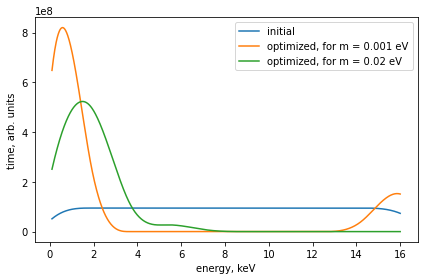

In [16]:
time0 = np.array([T(x, x_knots, b0) for x in energy])
time1 = np.array([T(x, x_knots, b1) for x in energy])
time1 = time1*np.sum(time0)/np.sum(time1)
time2 = np.array([T(x, x_knots, b3) for x in energy])
time2 = time2*np.sum(time0)/np.sum(time2)

plt.plot(energy, time0, label='initial')
plt.plot(energy, time1, label='optimized, for m = 0.001 eV')
plt.plot(energy, time2, label='optimized, for m = 0.02 eV')

plt.legend()
plt.xlabel('energy, keV')
plt.ylabel('time, arb. units')
plt.tight_layout()
#plt.savefig('axion_strategy.png', dpi=300, transparent=True)

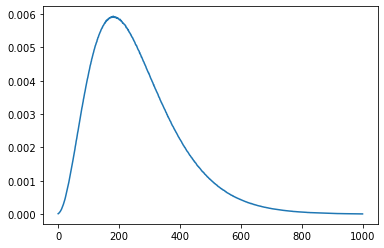

In [11]:
np.random.seed(42)
time = np.array([T(x, x_knots, b0) for x in energy])
y = np.random.poisson(numbers*time)/time
plt.plot(y)

In [49]:
popt, pcov = optimize.curve_fit(f = experiment, xdata = energy, ydata = y,
                                p0 = [m,  0, 1], sigma = np.sqrt(numbers*time)/time, absolute_sigma = True,
                                bounds = ((0, -500, 0), (1., 500, 2.)))

s = np.sqrt(np.diag(pcov))
print(popt)
print(s)
print(popt[0]-s[0], m, popt[0]+s[0])

[ 8.02454887e-08 -1.34025564e-08  9.99888418e-01]
[0.00000000e+00 3.03378376e-08 7.79598317e-05]
8.024548868781483e-08 0.0001 8.024548868781483e-08


## Свертки

In [6]:
from scipy.integrate import quad
def integrateQ(func, a, b):
    res = quad(func, a,b)
    return res[0]

def integrateR(func, a, b, numPoints = 1000):
    points, step = np.linspace(a, b, numPoints, endpoint=True, retstep=True)
    return np.sum(func(points))*step

from scipy.integrate import simps
def integrateS(func, a, b, numPoints = 1000):
    x = np.linspace(a,b, numPoints, endpoint=True)
    return simps(x = x, y = func(x))

integrate = integrateQ

In [13]:
convolute = lambda f, g, a, b: np.vectorize(lambda x: integrate(lambda y: f(x-y)*g(y), a, b))
sigma = 0.1
g = lambda x : 1/np.sqrt(2*np.pi)/sigma*np.exp(-x*x/2/sigma/sigma)
time = lambda x : T(x, x_knots, b1)
time = np.vectorize(time)

In [15]:
%%time
conv = convolute(time, g, a0, a1)(energy)

Wall time: 2min 3s


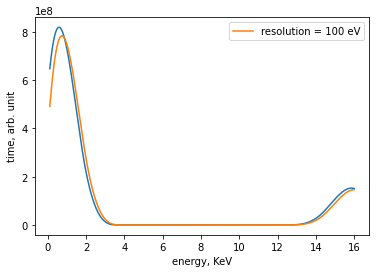

In [18]:
y0 = np.array([T(x, x_knots, b0) for x in energy])
conv_normed = conv*np.sum(y0)/np.sum(conv)
plt.plot(energy, time1)
plt.plot(energy, conv_normed, label='resolution = 100 eV')
plt.xlabel("energy, KeV")
plt.ylabel("time, arb. unit")
plt.legend()
#plt.savefig("figs/convolute_strategy_gaus_1_quad.png", dpi=150)

In [19]:
def inversed_fisher_information_time(time, derivatives, KEs, dist):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    
    length = len(derivatives)
    FIM = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    return np.sqrt(np.linalg.inv(FIM)[0][0])

In [21]:
inversed_fisher_information_time(
    y0, derivatives, energy, numbers)/inversed_fisher_information_time(conv_normed, derivatives, energy, numbers)

2.681429836420379

In [36]:
from numpy import trapz
def smear(dN,E,E_res):
    # Smear spectrum dN(E) by energy resolution Eres
    # dN = spectrum (arbitrary units)
    # E = Energies defining dN
    # E_res = Energy resolution to smear by
    n = np.size(dN)
    Norm = 1.0/np.sqrt(2*np.pi*E_res**2.0)
    dN_smeared = np.zeros(shape=n)
    for i in range(0,n):
        # Each new energy is the full spectrum convolved by a gaussian
        K = Norm*np.exp(-(E-E[i])**2.0/(2*E_res**2.0))
        dN_smeared[i] = trapz(K*dN,E)
    return dN_smeared

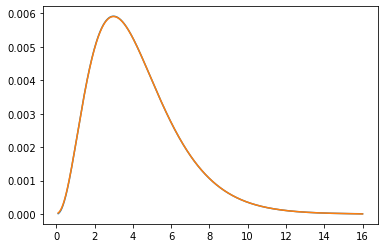

In [40]:
spectrum_conv = smear(PhotonNumber_Primakoff(energy, 0.001), energy, 0.1)
plt.plot(energy, numbers)
plt.plot(energy, spectrum_conv)

In [24]:
spectrum = lambda x: PhotonNumber_Primakoff(x, 0.001)
spectrum = np.vectorize(spectrum)

In [25]:
spectrum_conv = convolute(spectrum , g, a0, a1)(energy)

<ipython-input-3-b8290113365b>:11: RuntimeWarning: invalid value encountered in double_scalars
  return norm*((E**2.481)/np.exp(E/1.205))*(np.sinc(normq/np.pi*m_a**2.0/E))**2.0  # keV^-1


TypeError: can't convert complex to float

In [17]:
#using emcee

In [63]:
def log_likelihood(theta, energy, y, time):
    mass, noise, calibr = theta
    model = experiment(energy, mass, noise, calibr)
    data = model*time
    data[data<=0] = 10e-19
    sigma = np.sqrt(data)/time
    sigma[sigma<=0] = 10e-19
    return -0.5 * np.sum((y - model) ** 2 / sigma**2 + np.log(sigma**2))

In [154]:
def log_prior(theta):
    mass, noise, calibr = theta
    if m/9 < mass < 9*m and -100.0 < noise < 100.0 and 0. < calibr < 2.0:
        return 0.0
    return -np.inf

In [155]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [42]:
bo = [5.75616546, 0.        , 0.        , 0.        , 2.96976327,
       0.91182758, 0.        , 0.        , 0.        , 0.23220813] #from neutrinos
b1 = [3.49103008, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.65695738] #for m=0.001
b2 = [4.99999939e+01, 1.26775429e-05, 2.51120106e-05, 2.70896555e-04,
       6.68700036e-05, 6.28279879e-05, 5.70137582e-05, 9.94056182e-06,
       5.16127349e-05, 1.03665135e+01] #for m=0.001 with annealing
b3 = [2.16081462, 3.15161278, 0.        , 0.19480526, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ] #for m=0.02
b4 = [ 0.02994217,  0.        , 14.29185946,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ] #for m=0.1
b5 = [3.59891016, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.74269773] # for m = 0.0001
b6 = [3.4897377 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.71435627] # for m = 0.00065


In [388]:
#[0.1, 0.02, 0.001, 0.0001]
m = 0.001
numbers = PhotonNumber_Primakoff(energy, m)

In [341]:
for k in range(10):
    y = np.random.poisson(numbers*time)/time 
    #np.random.seed(93284)
    pos = np.array([m, 0, 1]) + 1e-4 * np.random.randn(24, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(energy, y, time))
                                    #moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2),])
    sampler.run_mcmc(pos, 1000)
    
    #samples = sampler.get_chain()
    labels = ["mass", "noise", "calibr"]
    flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
    
    print(np.percentile(flat_samples[:, 0], [16, 50, 84]))
    

C:\ProgramData\Anaconda3\lib\site-packages\emcee\ensemble.py:255: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  warnings.warn(


[0.00078546 0.00087964 0.00094666]
[0.00098452 0.00103199 0.0010785 ]
[0.00093053 0.00098703 0.00103466]
[0.00098425 0.00103288 0.00107466]
[0.00102709 0.00107055 0.00111067]
[0.0009815  0.00102789 0.00107236]
[0.00095695 0.00101149 0.00105712]
[0.00088718 0.00095516 0.00100551]
[0.00095443 0.00100654 0.00105184]
[0.00090705 0.00096622 0.001022  ]


In [389]:
np.random.seed(42)
y0 = np.array([T(x, x_knots, b0) for x in energy])
b=b1
time = np.array([T(x, x_knots, b) for x in energy])
time = time*np.sum(y0)/np.sum(time)

y = np.random.poisson(numbers*time)/time 
y00 = np.random.poisson(numbers*y0)/y0 

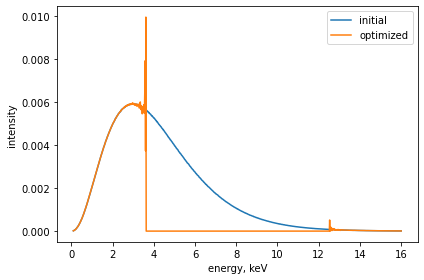

In [390]:
plt.plot(energy, y00, label='initial')
plt.plot(energy, y, label='optimized')
plt.legend()
plt.xlabel('energy, keV')
plt.ylabel('intensity')
plt.tight_layout()
#plt.savefig('figs_pres/axion_spectrum_m_02.png', dpi=300, transparent=True)

In [365]:
%%time
np.random.seed(93284)
pos = np.array([m, 0, 1]) + 1e-4 * np.random.randn(24, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(energy, y, time))
                                #moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2),])
sampler.run_mcmc(pos, 5000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 213.99it/s]

Wall time: 23.4 s


State([[ 1.02964822e-03  1.09015718e-08  1.00009479e+00]
 [ 9.90046517e-04 -4.87858784e-09  1.00016035e+00]
 [ 1.03793113e-03 -3.44024564e-08  1.00016742e+00]
 [ 1.05033470e-03  1.23075824e-08  1.00007923e+00]
 [ 1.01739555e-03  2.27833893e-08  9.99987242e-01]
 [ 1.06746875e-03  2.04773454e-08  1.00017446e+00]
 [ 1.05822035e-03  4.34556346e-08  1.00007739e+00]
 [ 1.01975498e-03 -4.99999406e-08  1.00011517e+00]
 [ 9.97835138e-04 -5.22519949e-08  1.00009295e+00]
 [ 1.03320432e-03  4.38468016e-09  1.00011530e+00]
 [ 1.08205858e-03  2.55674039e-08  1.00011276e+00]
 [ 1.10079667e-03  1.59471658e-08  1.00007559e+00]
 [ 1.07828004e-03 -3.19733175e-09  1.00021213e+00]
 [ 1.00473710e-03 -5.93181897e-09  9.99912019e-01]
 [ 9.77506503e-04  1.29777635e-08  9.99923796e-01]
 [ 1.01963784e-03  3.36308638e-08  1.00013176e+00]
 [ 9.65609786e-04  3.43625279e-08  1.00007567e+00]
 [ 9.95069081e-04  2.69880825e-08  1.00007037e+00]
 [ 9.97849033e-04 -6.05848107e-09  1.00003857e+00]
 [ 1.01978089e-03 -3.9252

Text(0.5, 0, 'step number')

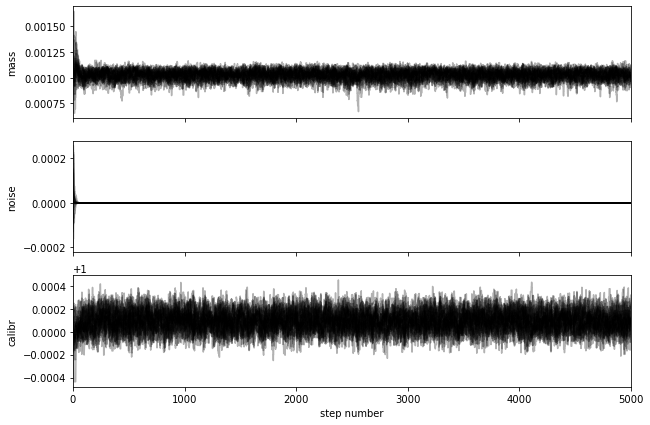

In [366]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mass", "noise", "calibr"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [367]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

[36.53046867 13.3648229  38.55377395]
(7512, 3)


In [291]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [368]:
print(m)
for i in range(ndim):
    print(np.percentile(flat_samples[:, i], [16, 50, 84]))

0.001
[0.00098126 0.00102898 0.00107145]
[-2.27885675e-08  7.89136502e-09  3.80902633e-08]
[1.00000864 1.0000929  1.00017821]


In [340]:
print(m)
for i in range(ndim):
    print(np.percentile(flat_samples[:, i], [16, 50, 84]))

0.001
[0.00079157 0.00087955 0.00094589]
[-9.49814596e-08 -6.49184196e-08 -3.56805677e-08]
[0.99993682 1.00002381 1.00011344]


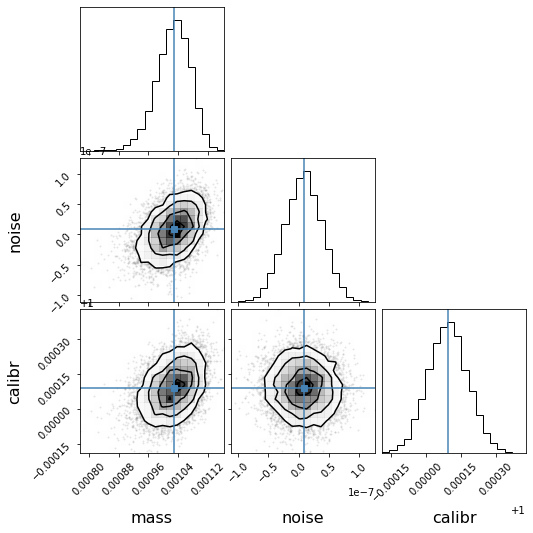

In [369]:
centers = np.zeros(ndim)
for i in range(ndim):
    centers[i] = np.percentile(flat_samples[:, i], [16, 50, 84])[1]

emcee_corner = corner.corner(flat_samples,labels=labels, truths=centers,
                            label_kwargs={"fontsize": 16}, labelpad=0.1)

#plt.savefig('figs_pres/axion_parameters_space_optimized_weights_m_0001.png', dpi=300, transparent=True)

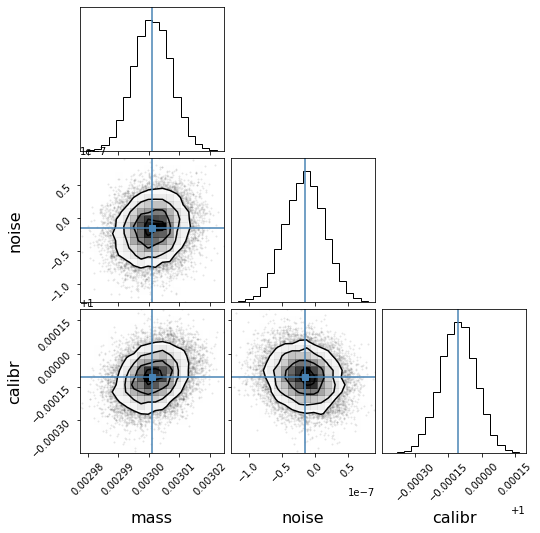

In [304]:
enters = np.zeros(ndim)
for i in range(ndim):
    centers[i] = np.percentile(flat_samples[:, i], [16, 50, 84])[1]

emcee_corner = corner.corner(flat_samples,labels=labels, truths=centers,
                            label_kwargs={"fontsize": 16}, labelpad=0.1)

In [253]:
flat_samples.T[0]

array([0.00065637, 0.00079236, 0.00087549, ..., 0.00069614, 0.00056749,
       0.00028376])

In [46]:
k = 100
ms = np.linspace(0.0001, 0.1, k)
erros_fisher = np.zeros(k)
erros_fit = np.zeros(k)
b=b0
for i in range(k):
    numbers = PhotonNumber_Primakoff(energy, ms[i])
    derivatives = np.array([div_mass(energy, ms[i]), np.ones(n), div_cal(energy, ms[i])]) 
    erros_fisher[i] = inversed_fisher_information(b, x_knots, derivatives, energy, numbers)
    pcovs = np.zeros(10)
    for j in range(10):
        time = np.array([T(x, x_knots, b) for x in energy])
        y0 = np.array([T(x, x_knots, b0) for x in energy])
        time = time * np.sum(y0)/np.sum(time)
        y = np.random.poisson(numbers*time)/time
        popt, pcov = optimize.curve_fit(f = experiment, xdata = energy, ydata = y,
                                        p0 = [ms[i],  0, 1], sigma = np.sqrt(numbers*time)/time, absolute_sigma = True,
                                        bounds = ((0, -500, 0), (3*ms[i], 500, 2.)))
        pcovs[j] = np.sqrt(pcov[0][0])
    erros_fit[i] = np.mean(pcovs)

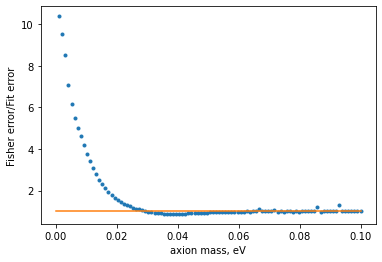

In [48]:
ratio = erros_fisher/erros_fit
plt.plot(ms[ratio<100], ratio[ratio<100], '.', label='optimized weights')
#plt.plot(ms, erros_fisher, '.')
plt.plot(ms, np.ones(k))
plt.xlabel('axion mass, eV')
plt.ylabel('Fisher error/Fit error')
#plt.legend()
#plt.savefig('figs_pres/ratio_errors_fisher_fit_initial_weights.png', dpi=300)

In [73]:
erros_fisher/erros_fit

array([9.66117829, 8.16592454, 9.5769082 , 8.51023418, 7.07210746,
       6.16991557, 5.49997508, 5.01729628, 4.61093826, 4.19190598,
       3.76904121, 3.40533369, 3.07338188, 2.78223599, 2.52478444,
       2.30652259, 2.10233045, 1.93195093, 1.78430427, 1.65778458,
       1.54666099, 1.45174495, 1.36981778, 1.29937042, 1.23775893,
       1.18386057, 1.13575922, 1.09214029, 1.05334079, 1.01765799,
       0.98588645, 0.95776377, 0.94373599, 0.91549014, 0.90194272,
       0.89093305, 0.88443005, 0.88244261, 0.87970861, 0.88194767,
       0.8845919 , 0.89086217, 0.89761296, 0.91780459, 0.91004323,
       0.91527106, 0.92414254, 0.93089662, 0.93776481, 0.94596555,
       0.95095401, 0.95821545, 0.96413076, 0.96882887, 0.97466573,
       0.98234666, 0.98386189, 0.98775678, 0.98688791, 0.99075917,
       0.99404169, 0.99357631, 0.9959721 , 0.99582223, 0.99654292,
       1.00211056, 1.11710942, 1.01337104, 0.99537923, 1.00613196,
       0.99631133, 1.0443213 , 0.99646097, 1.00298911, 0.99638

In [136]:
y0 = np.array([T(x, x_knots, b0) for x in energy])
y1 = np.array([T(x, x_knots, bo) for x in energy])
y1 = y1*np.sum(y0)/np.sum(y1)
y2 = np.array([T(x, x_knots, b3) for x in energy])
y2 = y2*np.sum(y0)/np.sum(y2)
y3 = np.array([T(x, x_knots, b2) for x in energy])
y3 = y3*np.sum(y0)/np.sum(y3)

traces = [go.Scatter(x = energy, y = y0, name = "initial"),
          go.Scatter(x = energy, y = y1, name = "optimized from neutrino"),
          go.Scatter(x = energy, y = y2, name = "optimized, for m=0.02 eV"),
          go.Scatter(x = energy, y = y3, name = "optimized, for m=0.001 eV")
         ]
fig = go.Figure(traces)

fig.update_layout(title="Strategy",
          xaxis_title="energy, KeV",
          yaxis_title="time, arb. unit",
          legend_title="weights")

#fig.write_image("axion_figs/strategy_diff_weights.png", scale=3)
fig.show()

In [358]:
K = 5000
popts = np.zeros((K, 3))
for k in range(K):
    y = np.random.poisson(numbers*time)/time 
    popt, pcov = optimize.curve_fit(f = experiment, xdata = energy, ydata = y,
                                p0 = [m,  0, 1], sigma = np.sqrt(numbers*time)/time, absolute_sigma = True,
                                bounds = ((0, -500, 0), (1., 500, 2.)))
    popts[k] = popt

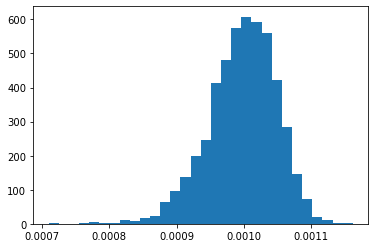

In [359]:
plt.hist(popts.T[0], bins=30)
plt.show()

In [356]:
y0 = np.array([T(x, x_knots, b0) for x in energy])
b=b2
time = np.array([T(x, x_knots, b) for x in energy])
time = time*np.sum(y0)/np.sum(time)

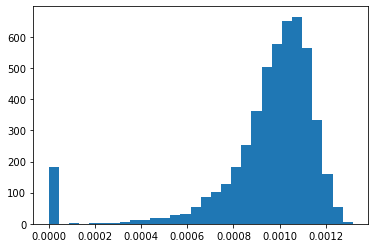

In [357]:
plt.hist(popts.T[0], bins=30)
plt.show()